In [2]:
import torch
from torch.utils.data import DataLoader
import os
import pandas as pd
from work.utils.dataset import PandasDataset, RGB2Fusion
from work.utils.models import EfficientNet
from work.utils.metrics import evaluation
from sklearn.metrics import confusion_matrix
import albumentations

In [3]:
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../efficientnet-b0-08094119.pth'
}
data_dir = '../../dataset'
images_dir = os.path.join(data_dir, 'tiles')

df_test = pd.read_csv(f"../data/test.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dimensions = 5

In [4]:
print("Cuda", device)

Cuda cuda


In [5]:
transform =albumentations.Compose([
    RGB2Fusion(mode="mean", space_colors=["rgb", "xyz", "lab"]),
])

In [6]:
dataloader = DataLoader(
    PandasDataset(images_dir, df_test, transforms=transform),
    batch_size=2,
    shuffle=False,
)

In [7]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_dimensions,
    pre_trained_model=pretrained_model
)
model.to(device)
model.load_state_dict(
    torch.load(
        "models/fusion-mean.pth",
        weights_only=True
    )
)

response_0 = evaluation(model, dataloader, device)
print("without treatment", response_0[0])
cm_0 = confusion_matrix(response_0[1][1], response_0[1][0])

Loaded pretrained weights for efficientnet-b0


100%|██████████| 796/796 [34:59<00:00,  2.64s/it]


without treatment {'val_acc': {'mean': 62.26551511287689, 'std': 1.2065856355745124, 'ci_5': 60.23869514465332, 'ci_95': 64.19597864151001}, 'val_kappa': {'mean': 0.8557495962293327, 'std': 0.009967682837194422, 'ci_5': 0.8383997066577505, 'ci_95': 0.8712246801280371}, 'val_f1': {'mean': 0.56666341650486, 'std': 0.012859488230289559, 'ci_5': 0.5458944529294968, 'ci_95': 0.5876530885696412}, 'val_recall': {'mean': 0.5655747563242912, 'std': 0.01296051677321943, 'ci_5': 0.5440900385379791, 'ci_95': 0.5867811143398285}, 'val_precision': {'mean': 0.582631072819233, 'std': 0.012660972746298123, 'ci_5': 0.5619777828454972, 'ci_95': 0.6037264198064805}}


In [8]:
matriz = confusion_matrix(response_0[1][1], response_0[1][0])
print(matriz)

[[364  42  17   7   4   0]
 [ 46 270  73  11   0   0]
 [  6  42 102  44   7   0]
 [  2   5  38  79  56   6]
 [  3   7  17  34  96  30]
 [  4   3   6  19  72  80]]


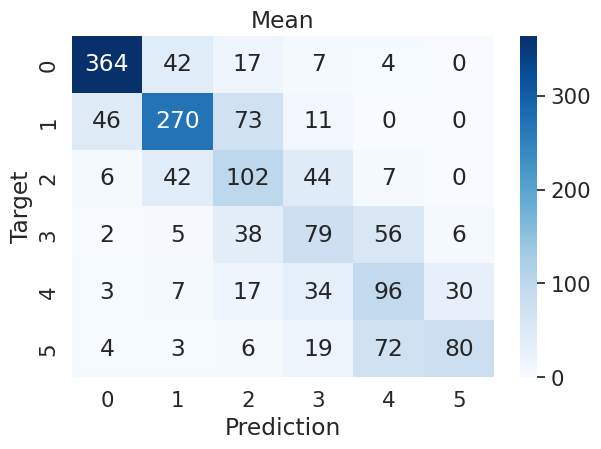

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.4)
sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Mean")
plt.tight_layout()
plt.show()